# Udacity Machine Learning Nanodegree Capstone Project

## Dog Breed Classifier

#### George Xian Wee



## Project Defintion

### Overview

This project is a dog breed classifier which integrates several components to create a simple application. The project falls under the research domain of image recognition, a field in machine learning where some of the biggest breakthroughs have been made, starting with a convolutional neural network winning the 2012 ImageNet Large Scale Visual Recognition Challenge. Subsequent competitions improved upon those results which propelled deep learning and machine learning into the spotlight. We have since seen a Cambrian explosion of research advancements and industry applications. 

### Problem Statement

This project addresses classification problems using supervised learning. The inputs are images of dogs and human faces. The application will determine if the image contains a dog (will classify image as dog/not dog). If there is a dog in the image, a convolutional neural network will take the dog image as an input and the output will be a prediction of the breed of the dog. If there is not a dog in the image, the application will detect if there is a human face in the image. If there is, a CNN will output a prediction of which kind of dog breed the human face most resembles. If there is not a human the application will display a message indicating that neither a dog nor human was found. 

### Metrics

In this project accuracy (number of correct predictions / total number of predictions is used as the primary metric for evalution and is suitable because the data is fairly balanced, meaning the training, validation and test data have roughly the same number of examples of dogs from each breed. A balanced dataset is important because, if, for example, the 90% of the test data images were of a specific breed, then a default prediction of that breed would yield 90% accuracy.

## Analysis

### Data Exploration and Visualization

The dataset provided by Udacity contains 8351 dog images and 13233 human images. Each dog and human image in its raw form may vary in it’s pixel dimensions. 





In [1]:
import numpy as np
import pandas as pd
from glob import glob

human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

In [2]:
import cv2             
import matplotlib.pyplot as plt                        
%matplotlib inline                               

def display_image(img_path):
    # load color (BGR) image
    img = cv2.imread(img_path)

    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    plt.show()

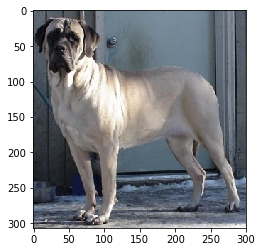

In [3]:
dog_img_path = dog_files[1]
display_image(dog_img_path)

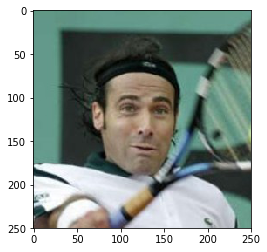

In [4]:
human_img_path = human_files[1]
display_image(human_img_path)

## Methodology

### Data Preprocessing

The images were accessed using the Python Image Libary (PIL) and were transformed to 224 x 224 pixels, converted to tensors and normalized. After the image transformations, a sample dog or human image would have dimensions 1 x 3 x 224 x 224 (torch.Size([1, 3, 224, 224])), meaning the first tensor contains 3 tensors representing RGB values of 224 x 224 image. Each pixel is an input into the initial layer of the neural network upon which the first convolutional layer would apply filters.

The images were normalized with a mean values [0.485, 0.456, 0.406] and standard deviation values [0.229, 0.224, 0.225]. Since PyTorch's ResNet model was used as the starting point for transfer learning, I used the recommended mean and standard deviation values from PyTorch's ResNet documentation. https://pytorch.org/hub/pytorch_vision_resnet/ 

To obtain better training results, images are transformed into uniform dimensions by first resizing them to 256 pixels and the center cropping to 224 pixels. Because I'm using a PyTorch's pre-trained model as the basis for transfer learning, I chose to use the same dimensions for my training, validation and test data as the dimensions used to pre-train the PyTorch ResNest model.

### Implementation and Refinement
First I defined, trained, validated and tested a convolutional neural network from scratch. The CNN contains 2 layers of convolutions which produce features used by a final fully connected layer that takes in the features and makes outputs predictions. The first convolutional layer has 3 input channels to account for the 3 dimensions of R, G, B values, 6 output channels, a kernel size of 5 for each sliding filter and a stride of 1. Generally, odd numbers are chosen for kernel sizes in the convolutional layer to avoid distortions that occur across layers with even numbered kernel sizes. Common kernel sizes in convolutional layers are 3x3, 5x5 and 7x7. Smaller strides tend to encode more information and maintain translational invariance, meaning the effect of the position of the object in the image is reduced. The second convolutional layer has 6 input channels which is the same number of output channels as from layer 1, 16 output channels and a kernal size of 5.

To downsample or reduce the dimensionality of each layer, max pooling was used to obtain the maximum value from the activated features in the previous layer (the maximum activation). A kernel size and stride of 2 were chosen, which is consistent with common practice. A small kernel size and stride in pooling prevents discarding too much information from the previous layer. 

Finally, fully connected layers take in the features from the convolutional layers and produces output predictions. The input layer has 16 * 5 * 5 parameters (the number of outputs from final convolutional layer mulitiplied by the dimension of the filters in the 2nd convolutional layer). The hidden layers consist of 120 and 84 neurons. There are a few empirically driven rules of thumb when choosing the number of hidden neurons. In general, the number of hidden neurons should be between the number of input and output parameters. Too few hidden neurons may result in underfitting and too many hidden neurons may lead to overfitting. A common rule is to have the number of hidden neurons be roughly the average of the number of neurons in the input and output layers. The final layer contains 133 neurons which correspond to the 133 dog breeds in our dataset. Each neuron of the output layer is a probability assigned to each dog breed, our model's prediction of the type of dog breed in the image.

The prediction results of a neural network built from scratch and trained over 25 epochs of 64 images per batch was quite low, only about 1% accuracy (10/836). To substantially improve the performance, I employed a form of transfer learning to extract the features from a pre-trained neural network. I started with a pretrained neural network, ResNet18, a residual neural network, which is a convolutional neural network containing “skip connections” to simplify the network by using fewer layers for training and to avoid “vanishing gradients” problem (the gradients in the early layers of a neural network become extremely small and the network cannot learn how a small change in the parameter’s value will affect the output). 

Next I replaced the final prediction layer of the network with a fully connected layer with 512 input features (the output from the final convolutional later of the model) and 133 output nodes (the number of dog breeds in our dataset). The final layer was re-trained with Cross Entropy Loss criterion and stochastic gradient descent optimizer to update the parameters with a learning rate (how much to adjust each parameter based on the gradient) of .001 and a momentum (the accumulation of previous gradients to determine how much to update the parameters) of .9, a common value used in practice. Learning rates (typically ranging from .1 - .001) that are larger enable models to train faster but may lead to sub-optimal final weights while smaller learning rates train more slowly but may lead to better results. The result, discussed in the next section, substantially improved.

http://cs231n.github.io/convolutional-networks/
http://giant.uji.es/blog/convnet/convnet.html
https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
https://towardsdatascience.com/deciding-optimal-filter-size-for-cnns-d6f7b56f9363
https://www.quora.com/How-can-I-decide-the-kernel-size-output-maps-and-layers-of-CNN
https://arxiv.org/pdf/1606.02228v2.pdf
https://www.quora.com/How-does-one-determine-stride-size-in-CNN-filters
https://stats.stackexchange.com/questions/207195/translational-variance-in-convolutional-neural-networks
https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7
https://www.quora.com/Are-maxpooling-layer-kernel-sizes-in-CNNs-generally-smaller-than-convolutional-layer-kernel-sizes-Why
https://www.kaggle.com/pytorch/resnet18
https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33
https://www.quora.com/What-is-the-vanishing-gradient-problem
https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d



## Results

### Model Evaluation and Validation

To evaluate both the model created from scratch and the transfer learning model, I used the following validation process.

I accumulated the loss during each forward pass and computed the average validation loss by diving the total loss in each epoch by the number number of samples in the validation set. The model was validated on XXX number of images.

To track the progress of the training, I again kept track of the training loss in each epoch and calculated the average training loss.


### Justification

For the convolutional network built and trained from scratch, the results were poor. After training for 25 epochs, the training loss only decreased from 4.893726 to 4.876308. Validation loss was reduced from 4.892617 to 4.877803. The results of the model on the test set was similar - 4.871027 loss. The model was only able to achieve an accuracy of about 1% (10/836)

The results from transfer learning were substantally better. In epoch 1, the training loss started at 4.617218 and by epoch 25, was reduced to 0.639790. The validation loss began at 4.095313 and ended at 0.586960.

When the trained transfer model was tested on the test dataset, the model's loss was 0.798060 and achieved an accuracy of 81% (684/836).

To improve results of the cnn built from scratch and for the transfer learning model, I can experiment with adding more training epochs or turning the dial up on the learning rate by an order of magnitude to .01.


## Conclusion

In this project, images of dogs were preprocessed, a convolutional neural network was trained, validated and tested, and a function was written simulate an application that takes in an input image path, predict the breed of the dog or the type of breed a human most closely resembles.

Building a convolutional neural network that can achieve high accuracy from scratch was tougher than I expected. Initially I thought that by increasing the number of training epochs, I could increase the accuracy.
